In [1]:
%%capture
!unzip "/content/drive/MyDrive/Edu/CV/ProjectData/train_test_dataset.zip" -d "data"

In [213]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import tensorflow as tf
import tensorflow.keras.utils as utils
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
BATCH_SIZE = 32
COLOR_MODE = "rgb"
IMG_SIZE = (256, 256)
IMG_DEPTH = 3 if COLOR_MODE == "rgb" else 1

In [119]:
train_path = "/content/data/train_test_dataset/train"
test_path = "/content/data/train_test_dataset/test"

In [209]:
train_data = utils.image_dataset_from_directory(train_path,subset='training' ,validation_split=0.2, seed = 42, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                color_mode=COLOR_MODE)
valid = utils.image_dataset_from_directory(train_path,subset='validation' ,validation_split=0.2, seed = 42,  image_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                           color_mode=COLOR_MODE) 

Found 200 files belonging to 5 classes.
Using 160 files for training.
Found 200 files belonging to 5 classes.
Using 40 files for validation.


In [216]:
label_map = {i:name for i, name in enumerate(train_data.class_names)}

In [261]:
def get_numpy_from_tf_data(data):
  images_, labels_ = tuple(zip(*data))
  images_ = np.vstack(images_).astype(np.uint8)
  labels_ = np.hstack(labels_).reshape(-1,1).squeeze()

  return images_, labels_

In [290]:
images, labels = get_numpy_from_tf_data(train_data)

In [262]:
valid_img, valid_labels = get_numpy_from_tf_data(valid)

In [123]:
def extract_sift_features(img, sift:cv2.SIFT):
  try:
    kps, desc = sift.detectAndCompute(img, None)
    return desc
  except Exception as e:
    print(f"img: {img.shape}, {e}")
  

In [162]:
def get_data_features(images):
  sift = cv2.SIFT_create()

  img_desc_limits = []
  features = []
  for img in images:
    img_feats = extract_sift_features(img, sift)

    features.append(img_feats)
    img_desc_limits.append(len(img_feats))
  return features, img_desc_limits

In [163]:
def format_as_train_data(features):
  return np.vstack(features)

In [273]:
def bow_from_predictions(pred, img_desc_limits, image_count):
  accum_sum = 0
  bow = []
  for i in range(image_count):
    desc_indx_start = accum_sum
    desc_indx_end = accum_sum + img_desc_limits[i]

    img_descs = pred[desc_indx_start:desc_indx_end]

    bow.append(np.histogram(img_descs, bins=NO_CLUSTERS)[0])

    accum_sum += img_desc_limits[i]
  
  return np.vstack(bow)


In [669]:
NO_CLUSTERS = 50
kmeans = KMeans(NO_CLUSTERS)

In [670]:
def imgs_to_bow(imgs, validation=False):
  features, img_desc_limits = get_data_features(imgs)
  X = format_as_train_data(features)
  print(f"Clustering data shape: {X.shape}")

  if not validation:
    print("Fitting Kmeans..")
    kmeans.fit(X)

  pred = kmeans.predict(X)

  bow = bow_from_predictions(pred, img_desc_limits, imgs.shape[0])

  return bow

In [671]:
bow = imgs_to_bow(images)

Clustering data shape: (23980, 128)
Fitting Kmeans..


In [677]:
valid_bow = imgs_to_bow(valid_img, validation=True)

Clustering data shape: (5454, 128)


# Train Classifier on bow

In [704]:
tree = DecisionTreeClassifier(max_depth=6)

In [705]:
tree.fit(bow, labels)

DecisionTreeClassifier(max_depth=6)

In [706]:
tree.score(bow, labels)

0.89375

In [707]:
tree.score(valid_bow, valid_labels)

0.8

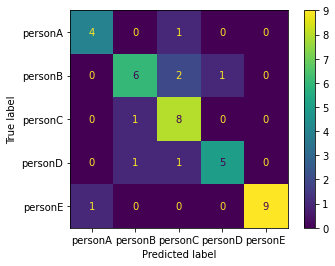

In [708]:
preds = tree.predict(valid_bow)
ConfusionMatrixDisplay.from_predictions(valid_labels, preds, display_labels=train_data.class_names)

# Random Forset Classifier

In [745]:
forest = RandomForestClassifier(max_depth=2, n_estimators=140)

In [746]:
forest.fit(bow, labels)

RandomForestClassifier(max_depth=2, n_estimators=140)

In [747]:
forest.score(bow, labels)

0.9

In [748]:
forest.score(valid_bow, valid_labels)

0.875

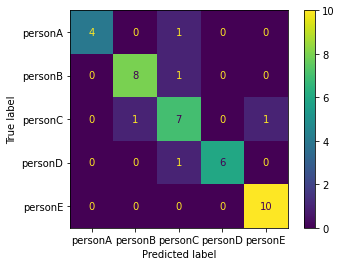

In [749]:
valid_preds = forest.predict(valid_bow)
ConfusionMatrixDisplay.from_predictions(valid_labels, valid_preds, display_labels=train_data.class_names)

# AdaBoost Classifier

In [750]:
from sklearn.ensemble import AdaBoostClassifier

In [785]:
ada = AdaBoostClassifier(learning_rate=0.01,n_estimators=120)

In [786]:
ada.fit(bow, labels)

AdaBoostClassifier(learning_rate=0.01, n_estimators=120)

In [787]:
ada.score(bow, labels)

0.85

In [788]:
ada.score(valid_bow, valid_labels)

0.825

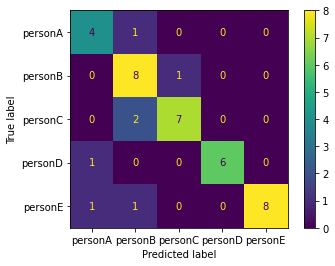

In [789]:
valid_preds = ada.predict(valid_bow)
ConfusionMatrixDisplay.from_predictions(valid_labels, valid_preds, display_labels=train_data.class_names)


# Gradient Boosting

In [790]:
from sklearn.ensemble import GradientBoostingClassifier

In [851]:
grad = GradientBoostingClassifier(learning_rate = 0.1,n_estimators=10, max_depth=2)

In [852]:
grad.fit(bow,labels)

GradientBoostingClassifier(max_depth=2, n_estimators=10)

In [853]:
grad.score(bow, labels)

0.9125

In [854]:
grad.score(valid_bow, valid_labels)

0.825

# SVM

In [660]:
from sklearn.svm import SVC

In [855]:
svm = SVC()

In [856]:
svm.fit(bow, labels)

SVC()

In [857]:
svm.score(bow, labels)

0.925

In [858]:
svm.score(valid_bow, valid_labels)

0.85